# Introduction

Il est important de ne pas montrer à l'utilisateur n'importe quel résultat car cela pourrait décridibiliser le robot. Au début notamment quand l'utilisateur n'a choisi qu'un thème et que les performances du retriever sont connues pour être encore faibles. 
Un moyen envisagé est de regarder dans quels dossiers se trouvent les fiches remontées par les retrievers. En fonction de la consistence de cette information, prendre une décision sur garder les fiches remontées ou alors demander à l'utilisateur de descendre dans l'arborescence. 
On utilise les résultats générés à partir des deux expériences suivantes : 
`
experiment_id,knowledge_base,test_dataset,lemma_preprocessing,k,dual_retriever_top_k,filter_level,retriever_type,nb_documents,correctly_retrieved,weighted_precision,precision,avg_time_s,date,hostname
a082,./data/v11,./data/407_question-fiche_anonym.csv,False,5,50,theme,sparse,324,157,True,0.3841931216931216,0.024913866912916652,2020-11-04_11-27-53,trololo-computer
267b,./data/v11,./data/407_question-fiche_anonym.csv,False,5,50,theme,dense,324,96,True,0.23055555555555557,0.18590225191215354,2020-11-04_11-30-44,trololo-computer
`

On agrège les résultats selon deux méthodes de calcul de la complémentarité différentes. 
Méthode 1: La complémentarité est calculée pour chaque fiche remontée par rapport à son poids sur les autres fiches :
```
def get_consistency_v1 (fiche, pred_fiche):
    nb = 0
    cnt = 0
    for pred in pred_fiche:
        cnt += 1
        if pred[4] == fiche[4]:
            nb +=1
    return nb/cnt
```
  

Dans la deuxième méthode chaque batch de fiches retrouvées se voit attribuer un score unique en fonction du nombre de fiches différentes dans le batch :
```
def get_consistency_v2 (fiche, pred_fiche):
    pred_fiche_names = []
    for pred in pred_fiche:
        pred_fiche_names.append(pred[4])
    nb = len(set(pred_fiche_names)) - 1
    cnt = len(pred_fiche)
    return 1 - nb/cnt
```

On cherche à trouver un moyen de rejeter les fiches si le score n'est pas bon.

# Methode 1

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
# on charge les résultats générés avec la méthode 1
df = pd.read_csv('./analysis_results_v1.csv')
df.head()

,question,fiche,fiche_ok,score_dense_no_lemma,score_sparse_no_lemma,score_dense_lemma,score_sparse_lemma,position_dense_no_lemma,position_sparse_no_lemma,position_dense_lemma,position_sparse_lemma,consistency_dense_no_lemma,consistency_sparse_no_lemma,consistency_dense_lemma,consistency_sparse_lemma,level
0,2825380_0,F2883,True,0.35315,33.481660,NaN,NaN,5.0,5.0,NaN,NaN,0.8,0.8,NaN,NaN,theme
1,2825380_0,F32431,False,NaN,34.728848,NaN,NaN,NaN,4.0,NaN,NaN,NaN,0.8,NaN,NaN,theme
2,2827357_0,F1028,False,0.19270,26.553139,NaN,NaN,5.0,1.0,NaN,NaN,0.8,0.8,NaN,NaN,theme
3,2827357_0,F31847,True,NaN,23.124060,NaN,NaN,NaN,5.0,NaN,NaN,NaN,0.8,NaN,NaN,theme
4,2832443_0,F1709,False,NaN,18.424984,NaN,NaN,NaN,5.0,NaN,NaN,NaN,0.4,NaN,NaN,theme


In [32]:
to_work = ['fiche_ok', 'consistency_dense_no_lemma', 'consistency_sparse_no_lemma']
X = df[to_work]
X.head()

,fiche_ok,consistency_dense_no_lemma,consistency_sparse_no_lemma
0,True,0.8,0.8
1,False,NaN,0.8
2,False,0.8,0.8
3,True,NaN,0.8
4,False,NaN,0.4


In [33]:
X.groupby(['fiche_ok'])[['consistency_dense_no_lemma', 'consistency_sparse_no_lemma']].mean()

,consistency_dense_no_lemma,consistency_sparse_no_lemma
fiche_ok,,
False,0.712005,0.620793
True,0.836905,0.797351


In [34]:
X.groupby(['fiche_ok'])[['consistency_dense_no_lemma', 'consistency_sparse_no_lemma']].std()

,consistency_dense_no_lemma,consistency_sparse_no_lemma
fiche_ok,,
False,0.280841,0.286519
True,0.209522,0.228224


On voit qu'il y a une différence de comportement plus fort sur l'indicateur de consistency pour le retriever sparse

## Visualisation sur le sparse

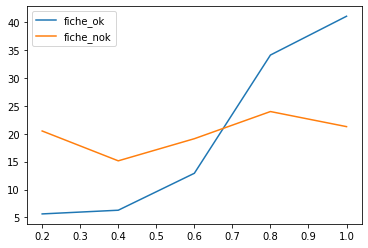

In [41]:
X_pass = X[X.fiche_ok == True]
grouped = X_pass.groupby(['consistency_sparse_no_lemma'])['consistency_sparse_no_lemma'].count()
total = grouped.sum()
unstack_pass = (grouped * 100)/total
plt.plot(unstack_pass, label = ('fiche_ok'))

X_failed = X[X.fiche_ok == False]
grouped = X_failed.groupby(['consistency_sparse_no_lemma'])['consistency_sparse_no_lemma'].count()
total = grouped.sum()
unstack_fail = (grouped * 100)/total
plt.plot(unstack_fail, label = ('fiche_nok'))
plt.legend()
plt.show()

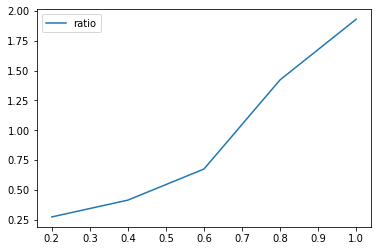

In [36]:
plt.plot(unstack_pass/unstack_fail, label = 'ratio')
plt.legend()
plt.show()

## Visualisation sur le dense

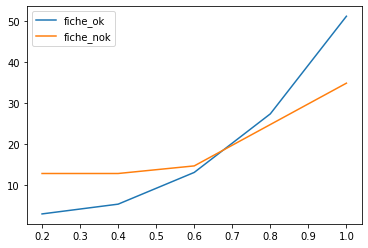

In [39]:
X_pass = X[X.fiche_ok == True]
grouped = X_pass.groupby(['consistency_dense_no_lemma'])['consistency_dense_no_lemma'].count()
total = grouped.sum()
unstack_pass = (grouped * 100)/total
plt.plot(unstack_pass, label = ('fiche_ok'))

X_failed = X[X.fiche_ok == False]
grouped = X_failed.groupby(['consistency_dense_no_lemma'])['consistency_dense_no_lemma'].count()
total = grouped.sum()
unstack_fail = (grouped * 100)/total
plt.plot(unstack_fail, label = ('fiche_nok'))
plt.legend()
plt.show()

# Methode 2

In [22]:
# on charge les résultats générés avec la méthode 1
df = pd.read_csv('./analysis_results_v2.csv')
df = df[df.level == 'theme']
to_work = ['fiche_ok', 'consistency_dense_no_lemma', 'consistency_sparse_no_lemma']
X = df[to_work]
X.head()

,fiche_ok,consistency_dense_no_lemma,consistency_sparse_no_lemma
0,True,0.8,0.8
1,False,NaN,0.8
2,False,0.8,0.8
3,True,NaN,0.8
4,False,NaN,0.4


In [43]:
X.groupby(['fiche_ok'])[['consistency_dense_no_lemma', 'consistency_sparse_no_lemma']].mean()

,consistency_dense_no_lemma,consistency_sparse_no_lemma
fiche_ok,,
False,0.712005,0.620793
True,0.836905,0.797351


In [44]:
X.groupby(['fiche_ok'])[['consistency_dense_no_lemma', 'consistency_sparse_no_lemma']].std()

,consistency_dense_no_lemma,consistency_sparse_no_lemma
fiche_ok,,
False,0.280841,0.286519
True,0.209522,0.228224


On voit qu'il y a une différence de comportement significatif sur l'indicateur de consistency pour le retriever sparse

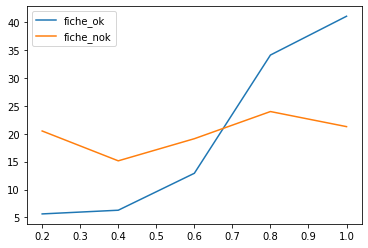

In [45]:
X_pass = X[X.fiche_ok == True]
grouped = X_pass.groupby(['consistency_sparse_no_lemma'])['consistency_sparse_no_lemma'].count()
total = grouped.sum()
unstack_pass = (grouped * 100)/total
plt.plot(unstack_pass, label = ('fiche_ok'))

X_failed = X[X.fiche_ok == False]
grouped = X_failed.groupby(['consistency_sparse_no_lemma'])['consistency_sparse_no_lemma'].count()
total = grouped.sum()
unstack_fail = (grouped * 100)/total
plt.plot(unstack_fail, label = ('fiche_nok'))
plt.legend()
plt.show()

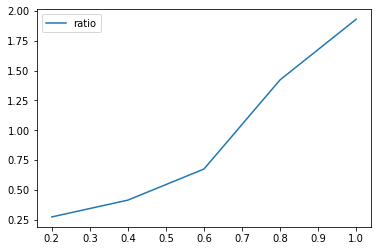

In [46]:
plt.plot(unstack_pass/unstack_fail, label = 'ratio')
plt.legend()
plt.show()

In [51]:
from sklearn.metrics import confusion_matrix, classification_report
to_work = ['fiche_ok', 'consistency_sparse_no_lemma']
X = df[to_work]
X = X.dropna()
y_true = X['fiche_ok']
y_pred = X['consistency_sparse_no_lemma'] > 0.5
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[ 593 1071]
 [  36  266]]
              precision    recall  f1-score   support

       False       0.94      0.36      0.52      1664
        True       0.20      0.88      0.32       302

    accuracy                           0.44      1966
   macro avg       0.57      0.62      0.42      1966
weighted avg       0.83      0.44      0.49      1966



# Conclusion
Il n'y a pas de grosse différence entre les deux méthodes. On peut prendre une limite de consistency à 0.5 pour choisir de rejeter les fiches 

# NEXT

faire la même chose pour déterminer le score limite pour le niveau dossier 